In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
import random

In [2]:
import pandas as pd

df = pd.read_csv("the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data.csv")

In [3]:
patient_id = list(df["Patient ID"])
recording_loc = list(df["Recording locations:"])
murmur = list(df["Murmur"])
murmur_loc = list(df["Murmur locations"])
systolic_murmur_timing = list(df["Systolic murmur timing"])

In [4]:
recording_loc = [x.split("+") for x in recording_loc]

for i in range(len(murmur_loc)):
    if murmur_loc[i] is np.nan:
        murmur_loc[i] = []
    else:
        murmur_loc[i] = murmur_loc[i].split("+")

In [5]:
X = []
y = []

for i in range(len(patient_id)):
    if murmur[i] == "Absent":
        for recloc in recording_loc[i]:
            full_recording = np.loadtxt("SSE/" + str(patient_id[i]) + "_" + recloc + "_features.csv", delimiter=',')
            initial = 0
            while (initial+400) <= len(full_recording):
                X.append(full_recording[initial:initial+400])
                y.append([1, 0, 0, 0, 0])
                initial += 200
    elif murmur[i] == "Present":
        for recloc in recording_loc[i]:
            if recloc in murmur_loc[i]:
                full_recording = np.loadtxt("SSE/" + str(patient_id[i]) + "_" + recloc + "_features.csv", delimiter=',')
                initial = 0
                if systolic_murmur_timing[i] == "Holosystolic":
                    while (initial+400) <= len(full_recording):
                        X.append(full_recording[initial:initial+400])
                        y.append([0, 1, 0, 0, 0])
                        initial += 200
                elif systolic_murmur_timing[i] == "Early-systolic":
                    while (initial+400) <= len(full_recording):
                        X.append(full_recording[initial:initial+400])
                        y.append([0, 0, 1, 0, 0])
                        initial += 200
                elif systolic_murmur_timing[i] == "Mid-systolic":
                    while (initial+400) <= len(full_recording):
                        X.append(full_recording[initial:initial+400])
                        y.append([0, 0, 0, 1, 0])
                        initial += 200
                elif systolic_murmur_timing[i] == "Late-systolic":
                    while (initial+400) <= len(full_recording):
                        X.append(full_recording[initial:initial+400])
                        y.append([0, 0, 0, 0, 1])
                        initial += 200
                else:
                    print("Error on patient ID:", patient_id[i])
            else:
                full_recording = np.loadtxt("SSE/" + str(patient_id[i]) + "_" + recloc + "_features.csv", delimiter=',')
                initial = 0
                while (initial+400) <= len(full_recording):
                    X.append(full_recording[initial:initial+400])
                    y.append([1, 0, 0, 0, 0])
                    initial += 200

Error on patient ID: 85119
Error on patient ID: 85119


In [6]:
time_steps = 400
feature_length = 18
batch_size = 3

In [7]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.25)

In [8]:
X_train_final = []
y_train_final = []

for i in range(len(X_train)):
    if y_train[i] == [1, 0, 0, 0, 0]:
        #randnum = random.uniform(0, 1)
        randnum = random.random()
        if randnum >= 0.66:
            X_train_final.append(X_train[i])
            y_train_final.append(y_train[i])
    else:
        X_train_final.append(X_train[i])
        y_train_final.append(y_train[i])

In [9]:
print(len(X_train), len(y_train))
print(len(X_train_final), len(y_train_final))
print(len(X_test), len(y_test))

22341 22341
10133 10133
7447 7447


In [10]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train_final = np.array(X_train_final)
y_train_final = np.array(y_train_final)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [11]:
model = Sequential()
model.add(LSTM(18, input_shape = (400, 18), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(18, return_sequences=False))
model.add(Dense(5, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 400, 18)           2664      
                                                                 
 dropout (Dropout)           (None, 400, 18)           0         
                                                                 
 lstm_1 (LSTM)               (None, 400, 64)           21248     
                                                                 
 dropout_1 (Dropout)         (None, 400, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 400, 32)           12416     
                                                                 
 dropout_2 (Dropout)         (None, 400, 32)           0         
                                                                 
 lstm_3 (LSTM)               (None, 18)                

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.fit(X_train_final, y_train_final, epochs=10, batch_size=batch_size)

Epoch 1/10


3378/3378 [==============================] - 1767s 520ms/step - loss: 0.9819 - accuracy: 0.6419
Epoch 2/10
3378/3378 [==============================] - 1648s 488ms/step - loss: 0.9687 - accuracy: 0.6424
Epoch 3/10
3378/3378 [==============================] - 1718s 509ms/step - loss: 0.9755 - accuracy: 0.6422
Epoch 4/10
3378/3378 [==============================] - 1731s 512ms/step - loss: 0.9648 - accuracy: 0.6444
Epoch 5/10
3378/3378 [==============================] - 1715s 508ms/step - loss: 0.9521 - accuracy: 0.6449
Epoch 6/10
3378/3378 [==============================] - 1777s 526ms/step - loss: 0.9620 - accuracy: 0.6454
Epoch 7/10
3378/3378 [==============================] - 1800s 533ms/step - loss: 0.9636 - accuracy: 0.6450
Epoch 8/10
3378/3378 [==============================] - 1806s 535ms/step - loss: 0.9577 - accuracy: 0.6498
Epoch 9/10
3378/3378 [==============================] - 1809s 535ms/step - loss: 0.9681 - accuracy: 0.6402
Epoch 10/10
3378/3378 [============

In [14]:
model.save_weights("v12weights.h5")

In [15]:
final_final_predicts = model.predict(X_test)
final_final_predicts.shape

233/233 [==============================] - 53s 215ms/step


(7447, 5)

In [16]:
X = np.array(X)
y = np.array(y)
score_full = model.evaluate(X, y, batch_size=batch_size, verbose=0)
print('Test loss:', score_full[0])
print('Accuracy:', score_full[1])

Test loss: 0.6719325184822083
Accuracy: 0.7678259611129761


In [17]:
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print('Test loss:', score[0])
print('Accuracy:', score[1])

Test loss: 0.6767668724060059
Accuracy: 0.7643346190452576


In [18]:
final_final_predicts

array([[7.8246516e-01, 1.2867406e-01, 6.4119123e-02, 2.4476742e-02,
        2.6494940e-04],
       [7.8244114e-01, 1.2868533e-01, 6.4134084e-02, 2.4474382e-02,
        2.6507583e-04],
       [7.8241795e-01, 1.2868510e-01, 6.4140007e-02, 2.4491875e-02,
        2.6508316e-04],
       ...,
       [7.7994287e-01, 1.2969978e-01, 6.5184213e-02, 2.4900844e-02,
        2.7221767e-04],
       [7.8120124e-01, 1.2911867e-01, 6.4701848e-02, 2.4710637e-02,
        2.6758629e-04],
       [7.8227079e-01, 1.2875845e-01, 6.4203471e-02, 2.4501419e-02,
        2.6584385e-04]], dtype=float32)

In [19]:
for i in range(len(final_final_predicts)):
    if max(final_final_predicts[i]) != final_final_predicts[i][0]:
        print(i, final_final_predicts[i])

7 [0.2637241  0.4892359  0.1613365  0.0796966  0.00600686]
10 [0.26128742 0.48979217 0.16252494 0.08027221 0.00612325]
14 [0.27438578 0.4762186  0.1639243  0.07961027 0.00586108]
26 [0.26231226 0.489228   0.16267088 0.07972333 0.00606545]
27 [0.26303974 0.4894054  0.16155373 0.07993934 0.00606172]
45 [0.26351166 0.48774266 0.16269733 0.08000033 0.00604797]
47 [0.26161593 0.48946798 0.16256759 0.08020791 0.00614066]
66 [0.2620209  0.48871505 0.16292639 0.08021244 0.00612528]
84 [0.2630478  0.4886725  0.1623303  0.07988507 0.00606428]
91 [0.29697686 0.4549972  0.16449606 0.07818104 0.00534876]
96 [0.26286706 0.4892302  0.16203731 0.07982283 0.00604256]
104 [0.26137218 0.4895451  0.16273728 0.08021703 0.00612849]
109 [0.36357084 0.38241667 0.18002093 0.07044885 0.00354272]
120 [0.2616625  0.4894296  0.16257432 0.08019636 0.00613727]
122 [0.25916985 0.49007368 0.16388687 0.08064339 0.00622618]
123 [0.264364   0.48841986 0.16136691 0.0798334  0.00601583]
141 [0.2630334  0.48939705 0.1615696

5030 [0.26070997 0.48973572 0.16307409 0.08033234 0.00614787]
5033 [0.34854794 0.39456552 0.18184838 0.07130372 0.00373445]
5036 [0.2596364  0.49061236 0.1635989  0.0799036  0.00624877]
5042 [0.26280728 0.48936787 0.16193584 0.07981855 0.00607048]
5044 [0.26378825 0.48916474 0.16118856 0.07983582 0.00602255]
5047 [0.26287973 0.48945314 0.16167372 0.07992701 0.00606645]
5048 [0.26242518 0.4886761  0.16271368 0.08008093 0.00610416]
5049 [0.2592416  0.49004757 0.16397275 0.08052314 0.00621488]
5050 [0.26210293 0.48860812 0.16296455 0.08019648 0.0061279 ]
5055 [0.26464075 0.48841688 0.16125801 0.07967556 0.00600874]
5065 [0.26345846 0.48922798 0.16147983 0.0798007  0.00603302]
5068 [0.26155224 0.48896983 0.1630781  0.08024981 0.00615   ]
5073 [0.26244953 0.4888085  0.16263194 0.08001519 0.00609481]
5082 [0.26217496 0.48960254 0.16206673 0.08007516 0.00608059]
5089 [0.26263517 0.48955303 0.16191871 0.07983819 0.00605485]
5091 [0.26723692 0.48514482 0.16213104 0.07954339 0.00594387]
5096 [0.

In [20]:
full_predicts = model.predict(X)
full_predicts

931/931 [==============================] - 203s 218ms/step


array([[7.8243071e-01, 1.2868321e-01, 6.4130366e-02, 2.4490656e-02,
        2.6511957e-04],
       [7.8247952e-01, 1.2866774e-01, 6.4120024e-02, 2.4467742e-02,
        2.6491066e-04],
       [7.8248590e-01, 1.2866546e-01, 6.4116769e-02, 2.4467018e-02,
        2.6487303e-04],
       ...,
       [7.8248644e-01, 1.2866405e-01, 6.4118430e-02, 2.4466136e-02,
        2.6492059e-04],
       [7.8250307e-01, 1.2865640e-01, 6.4112954e-02, 2.4462774e-02,
        2.6483982e-04],
       [7.8248876e-01, 1.2866352e-01, 6.4116195e-02, 2.4466628e-02,
        2.6487769e-04]], dtype=float32)

In [21]:
for i in range(len(full_predicts)):
    if max(full_predicts[i]) != full_predicts[i][0]:
        print(i, full_predicts[i])

12 [0.26015005 0.4897349  0.16341577 0.08051255 0.00618675]
34 [0.26295948 0.48983297 0.16125947 0.0798891  0.00605898]
35 [0.26242453 0.48937017 0.16206424 0.08005241 0.00608867]
36 [0.2627013  0.48960745 0.16161476 0.08000542 0.00607105]
37 [0.2639573  0.48949414 0.16087477 0.079675   0.0059988 ]
38 [0.26374078 0.48917285 0.16124368 0.07982064 0.00602196]
39 [0.26249552 0.48903745 0.16235256 0.08002842 0.00608608]
40 [0.26363224 0.4886391  0.16181701 0.07985521 0.00605654]
45 [0.28452793 0.45800075 0.1759729  0.07623111 0.00526736]
50 [0.2668882  0.48769468 0.16084585 0.07862302 0.00594828]
51 [0.26481244 0.48880857 0.16167814 0.07866673 0.00603414]
52 [0.26425162 0.48901156 0.16193107 0.0787285  0.00607726]
53 [0.26427993 0.48889163 0.16200493 0.07874923 0.00607424]
54 [0.26710033 0.48736623 0.16087036 0.07872257 0.00594049]
55 [0.26696774 0.488134   0.16050364 0.07844133 0.00595327]
56 [0.26497653 0.48926267 0.16123842 0.07845821 0.00606415]
57 [0.2605967  0.4905239  0.1628577  0.0

2680 [0.26296687 0.48924795 0.16177839 0.07994892 0.00605788]
2683 [0.26416463 0.48909482 0.16100611 0.07973189 0.00600261]
2684 [0.26396167 0.4894601  0.16093107 0.07965098 0.00599613]
2685 [0.26252264 0.48923436 0.16215359 0.07999645 0.00609294]
2686 [0.26235688 0.4887696  0.16271089 0.0800588  0.00610374]
2687 [0.2634123  0.489341   0.16156346 0.07967366 0.00600966]
2688 [0.26215473 0.4892404  0.16263753 0.07988311 0.00608423]
2689 [0.2624561  0.48872665 0.1626635  0.08004867 0.00610514]
2690 [0.26369438 0.48874602 0.1619016  0.07964179 0.00601623]
2691 [0.26382262 0.4895225  0.16087191 0.07977473 0.00600827]
2694 [0.26379564 0.4893743  0.1610431  0.07977116 0.00601572]
2698 [0.2632996  0.4893991  0.16134965 0.07990363 0.00604797]
2699 [0.31947052 0.43335748 0.16540092 0.07682797 0.00494317]
2706 [0.2620376  0.48890594 0.16274767 0.08018144 0.00612728]
2712 [0.2624119  0.48864615 0.16273859 0.08009723 0.00610614]
2713 [0.27818155 0.47000006 0.16799536 0.07819903 0.00562401]
2751 [0.

7486 [0.26111716 0.48948568 0.16340476 0.07987853 0.00611388]
7487 [0.33360428 0.41701967 0.16853735 0.07602961 0.00480911]
7488 [0.26419047 0.48876026 0.16161099 0.07946561 0.00597273]
7489 [0.2635837  0.4892613  0.16129234 0.0798322  0.00603057]
7490 [0.2633099  0.48911136 0.16174345 0.07981439 0.00602085]
7491 [0.26092482 0.4904911  0.16209799 0.08034948 0.00613671]
7494 [0.2624874  0.48880115 0.1625325  0.08007986 0.00609903]
7496 [0.26247934 0.48867968 0.16266946 0.08007686 0.00609468]
7497 [0.2620114  0.48910856 0.16261297 0.08014312 0.00612395]
7498 [0.2670162  0.484004   0.1630665  0.07989651 0.00601677]
7499 [0.26177108 0.48896316 0.16289301 0.08022794 0.00614484]
7500 [0.2628461  0.4898686  0.16123271 0.07999042 0.00606211]
7501 [0.26286352 0.4894752  0.16170563 0.07989611 0.0060596 ]
7502 [0.26155573 0.4892597  0.16291013 0.08014736 0.00612696]
7505 [0.26059124 0.4903984  0.16252625 0.08033158 0.00615254]
7509 [0.26302728 0.4894446  0.16149166 0.07998011 0.0060563 ]
7511 [0.

13378 [0.26263675 0.48977023 0.16159078 0.07993779 0.00606449]
13379 [0.26359555 0.48921463 0.16138461 0.0797767  0.00602854]
13383 [0.2624604  0.48934436 0.16208324 0.08001597 0.00609603]
13384 [0.26335356 0.48905993 0.1616895  0.07986603 0.00603103]
13393 [0.26234025 0.4886482  0.16278611 0.08011446 0.00611104]
13403 [0.26182073 0.48964444 0.16224524 0.08017647 0.00611321]
13404 [0.28363162 0.458087   0.17634007 0.07655965 0.00538166]
13452 [0.26324266 0.48917067 0.16161716 0.07992052 0.00604888]
13454 [0.26276284 0.48942    0.16168934 0.08004773 0.00608008]
13456 [0.2627081  0.48927158 0.16199343 0.07994239 0.00608453]
13457 [0.2622265  0.48877877 0.16277125 0.08011109 0.00611243]
13458 [0.26151305 0.4895395  0.16265231 0.08016646 0.00612871]
13459 [0.26174265 0.48941383 0.16249189 0.08022748 0.00612414]
13460 [0.2629266  0.48938864 0.16168764 0.07992961 0.00606747]
13461 [0.26146892 0.4890382  0.16309124 0.08024981 0.00615188]
13462 [0.26289076 0.48888302 0.16231348 0.0798532  0.00

21561 [0.36509728 0.38978434 0.16669594 0.07419528 0.00422719]
21567 [0.26230592 0.4884729  0.16292341 0.08017809 0.00611972]
21568 [0.26345524 0.4891092  0.16145031 0.079939   0.00604624]
21569 [0.26329857 0.48918644 0.16154207 0.07992278 0.00605015]
21570 [0.26231134 0.48872837 0.16275208 0.08009826 0.00610995]
21571 [0.2635638  0.48888206 0.16162366 0.07988714 0.00604326]
21574 [0.2632124  0.48918045 0.16168047 0.07988054 0.0060461 ]
21575 [0.26253557 0.48867655 0.16264546 0.0800453  0.00609718]
21576 [0.2621312  0.48862082 0.16293278 0.08018943 0.00612581]
21577 [0.26352534 0.48918158 0.1613726  0.07988162 0.00603882]
21578 [0.2620889  0.489316   0.16230999 0.08017994 0.00610517]
21579 [0.26111683 0.4895203  0.1628832  0.08032243 0.00615726]
21580 [0.2612494  0.48895803 0.16328931 0.08033471 0.00616854]
21581 [0.26188534 0.48870605 0.1629969  0.08027674 0.00613495]
21582 [0.2620472  0.4886335  0.16298138 0.0802074  0.00613051]
21583 [0.26212087 0.48861358 0.16294603 0.0801928  0.00

27887 [0.25907934 0.48987913 0.16414091 0.08067172 0.00622885]
27933 [0.27635533 0.4721293  0.16836788 0.07756308 0.00558449]
27945 [0.26219988 0.48865378 0.1628722  0.08015431 0.00611976]
27946 [0.2621133  0.48942262 0.16226223 0.08009837 0.00610352]
27948 [0.26304367 0.48899376 0.16188575 0.08000639 0.00607037]
27949 [0.26218832 0.4887045  0.1628393  0.08014876 0.00611909]
27950 [0.26291132 0.4898765  0.16120687 0.07995047 0.00605477]
27959 [0.2619708  0.48868135 0.16301678 0.08019885 0.00613224]
27977 [0.2631259  0.48928806 0.16163522 0.07989753 0.00605331]
27979 [0.26241046 0.48872325 0.16262779 0.08012917 0.00610926]
27980 [0.2622919  0.4887035  0.16272357 0.08016383 0.00611721]
27981 [0.2760226  0.47600263 0.16281463 0.0793751  0.00578499]
27982 [0.26319844 0.4891842  0.16164912 0.07991399 0.00605422]
27984 [0.26214126 0.49007204 0.16201943 0.07966579 0.00610143]
27985 [0.26302868 0.48993486 0.16147135 0.07951003 0.00605496]
27986 [0.26039943 0.490104   0.16341235 0.07988435 0.00

In [22]:
#%% Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report 

# Classification Report
model_report = classification_report(np.argmax(full_predicts, axis=1), np.argmax(y, axis=1))
print(model_report)

              precision    recall  f1-score   support

           0       0.88      0.87      0.88     24968
           1       0.36      0.22      0.27      4820
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.77     29788
   macro avg       0.25      0.22      0.23     29788
weighted avg       0.79      0.77      0.78     29788



C:\Users\savit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\savit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\savit\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
model_conf = confusion_matrix(np.argmax(full_predicts, axis=1), np.argmax(y, axis=1))
print(model_conf)

[[21821  1846   997   300     4]
 [ 3076  1051   478   200    15]
 [    0     0     0     0     0]
 [    0     0     0     0     0]
 [    0     0     0     0     0]]


In [24]:
#from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Learn to predict each class against the other


n_classes = 5 # number of class




# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], final_final_predicts[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), final_final_predicts.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

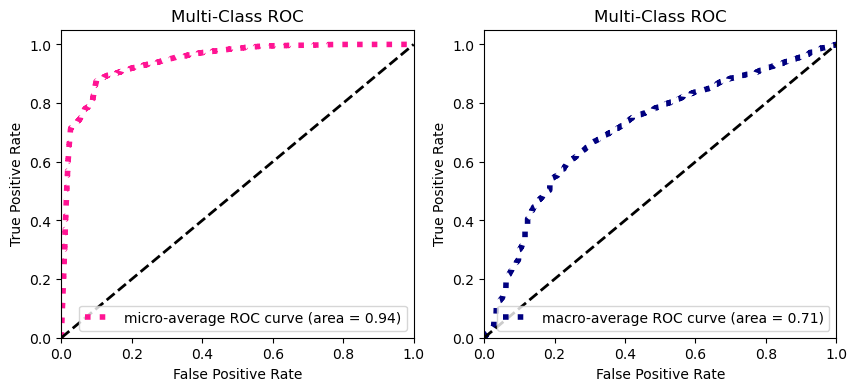

In [25]:
n_classes = 5

# Process of plotting roc-auc curve belonging to all classes.

from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC')
plt.legend(loc="lower right")

plt.subplot(122)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC')
plt.legend(loc="lower right")
plt.show()

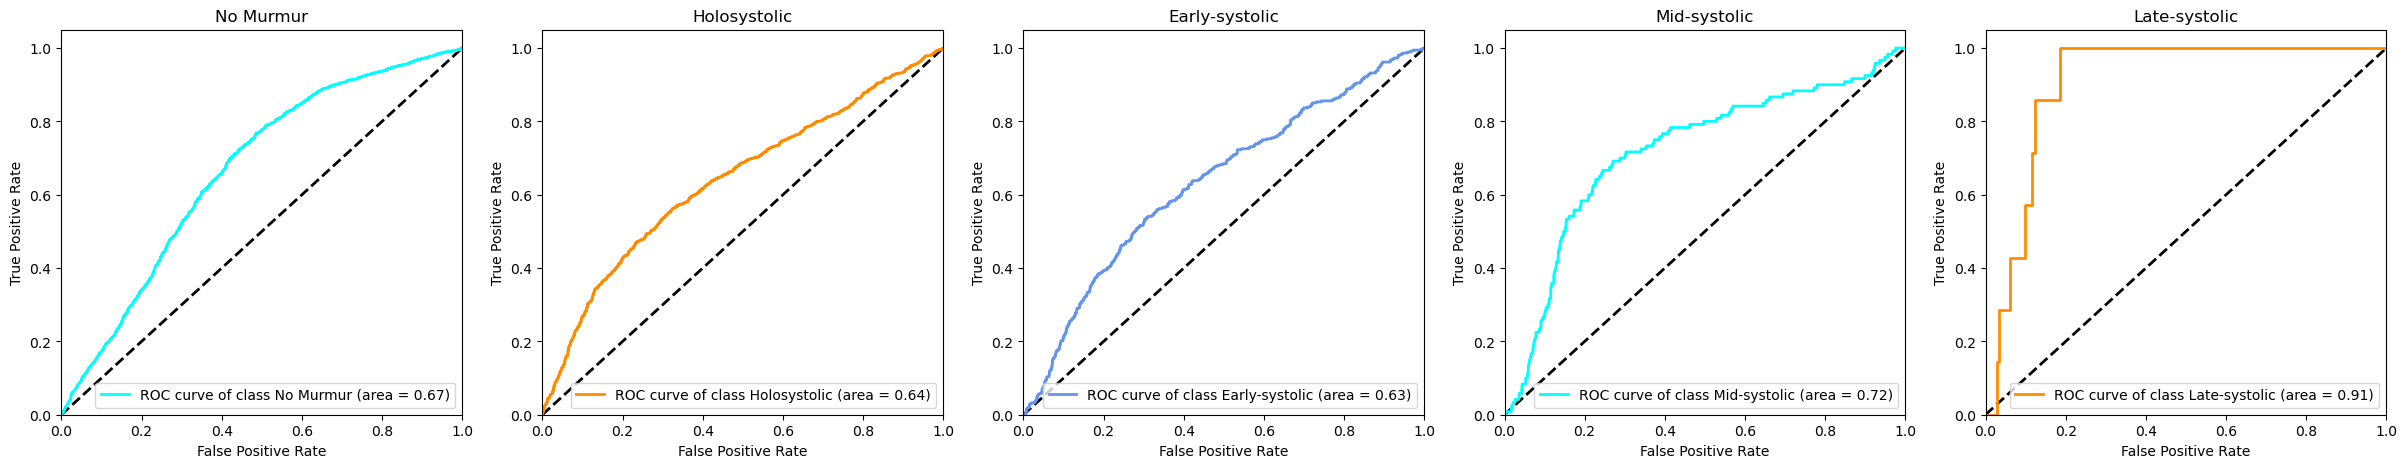

In [26]:
plt.close()
plt.figure(figsize=(30, 5))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
title = ['No Murmur', "Holosystolic", "Early-systolic", "Mid-systolic", "Late-systolic"]
for i, color in zip(range(n_classes), colors):
    if i == 0:
        plt.subplot(151)
    elif i == 1:
        plt.subplot(152)
    elif i == 2:
        plt.subplot(153)
    elif i == 3:
        plt.subplot(154)
    else:
        plt.subplot(155)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(title[i], roc_auc[i]))
    plt.legend(loc="lower right")
    
plt.show()